In [1]:
# 06_opponent_adjusted_ratings.ipynb
# 📈 Opponent-Adjusted Ratings

# Requirements: pandas, numpy, matplotlib, seaborn (install via `pip install pandas numpy matplotlib seaborn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("viridis")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())


Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🧮 Why Opponent Adjustments Matter

> **Beginner tip:** Strength-of-schedule math sounds intimidating, but each step below explains the transformation. Read the short note before every cell and the printed messages after it runs.

Raw net ratings can hide how much schedule strength inflates or deflates your metrics. In this notebook you will:
- confirm which seasons are packaged and choose a target season
- load game-level efficiency data for every matchup
- compute per-team Simple Rating System (SRS) values using opponent networks
- isolate strength-of-schedule (SOS) impact on raw net ratings
- surface leaders and outliers with tailored tables and visuals


In [2]:
# 📅 Discover available seasons
season_files = sorted(p.stem for p in (DATA_DIR / "team_season_stats").glob("*.csv"))
print(f"Available seasons ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))


Available seasons (21):
2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Choose analysis parameters
Stick with the defaults until you understand the workflow. Later you can limit the schedule to conference games or change the number of SRS iterations.

Update the season, optional conference, and minimum game requirement before rerunning the notebook.


In [11]:
# 🔁 Parameters
TARGET_SEASON = 2025  # change to any listing above
TARGET_CONFERENCE = None  # e.g. 'Big 12' or None for all teams
MIN_GAMES = 10  # drop small-sample teams from the SRS solve

print(f"Analyzing season: {TARGET_SEASON}")
print(f"Conference filter: {TARGET_CONFERENCE or 'All'}")
print(f"Minimum games required: {MIN_GAMES}")


Analyzing season: 2025
Conference filter: All
Minimum games required: 10


In [12]:
# 📥 Load season and game data
team_season_path = DATA_DIR / 'team_season_stats' / f'{TARGET_SEASON}.csv'
team_game_path = DATA_DIR / 'team_game_stats' / f'{TARGET_SEASON}.csv'

team_season = pd.read_csv(team_season_path)
team_games = pd.read_csv(team_game_path)

# Some rows may represent exhibitions or non-D1 opponents without conference tags
team_games = team_games.dropna(subset=['conference']).copy()

if TARGET_CONFERENCE:
    team_season = team_season[team_season['conference'] == TARGET_CONFERENCE].copy()
    team_games = team_games[team_games['conference'] == TARGET_CONFERENCE].copy()

print(f"Season rows: {len(team_season):,}")
print(f"Game rows: {len(team_games):,}")
display(team_season[['team', 'conference', 'games', 'wins', 'teamStats_rating', 'opponentStats_rating']].head())


Season rows: 364
Game rows: 12,042


/tmp/ipykernel_517503/4273934257.py:6: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  team_games = pd.read_csv(team_game_path)


,team,conference,games,wins,teamStats_rating,opponentStats_rating
0,Abilene Christian,WAC,32,16,103.80,103.50
1,Air Force,Mountain West,32,4,98.90,117.90
2,Akron,MAC,35,28,120.50,107.40
3,Alabama A&M,SWAC,32,10,114.70,124.50
4,Alabama,SEC,37,28,119.30,106.90


## 📊 Build per-game efficiencies
We transform each game into tempo-free ratings and margins. Skim the preview to make sure familiar teams line up with what you expect.

Convert the game log into net ratings and scoring margin so we can summarize each schedule.


In [13]:
# 🔢 Derive game-level metrics
game_ratings = (
    team_games.assign(
        net_rating=lambda df: df['teamStats_rating'] - df['opponentStats_rating'],
        scoring_margin=lambda df: df['teamStats_points_total'] - df['opponentStats_points_total'],
        possessions=lambda df: df['teamStats_possessions']
    )
    [[
        'teamId', 'team', 'conference', 'opponentId', 'opponent', 'gameId',
        'net_rating', 'scoring_margin', 'possessions'
    ]]
)

team_baselines = (
    game_ratings
    .groupby(['teamId', 'team', 'conference'], dropna=False)
    .agg(
        games_played=('gameId', 'count'),
        avg_net_rating=('net_rating', 'mean'),
        avg_margin=('scoring_margin', 'mean'),
        avg_possessions=('possessions', 'mean')
    )
    .reset_index()
)

eligible_baselines = team_baselines.query('games_played >= @MIN_GAMES').copy()

print(f"Teams in SRS solve: {len(eligible_baselines)} (of {len(team_baselines)})")
display(eligible_baselines.sort_values('avg_net_rating', ascending=False).head())


Teams in SRS solve: 364 (of 364)


,teamId,team,conference,games_played,avg_net_rating,avg_margin,avg_possessions
71,72,Duke,ACC,39,31.23,20.46,65.69
309,310,UC San Diego,Big West,35,26.68,17.54,66.82
101,102,Gonzaga,WCC,35,24.97,16.49,69.37
112,113,Houston,Big 12,40,23.80,15.00,63.02
86,87,Florida,SEC,40,21.89,15.18,69.72


## 🧠 Solve for SRS opponent adjustments
The iterative solver nudges ratings up or down based on opponent strength. Read the printed messages—they explain how close the model is to stabilizing.

Set up the standard linear system `SRS = MOV + SOS`, where SOS is the average SRS of your opponents. We estimate the solution with a least squares solve to handle disconnected schedules.


In [14]:
# 🧮 Build the SRS linear system
eligible_ids = eligible_baselines['teamId'].tolist()
if not eligible_ids:
    raise ValueError('No teams meet the minimum games requirement. Lower MIN_GAMES or adjust filters.')
id_to_idx = {team_id: idx for idx, team_id in enumerate(eligible_ids)}
n_teams = len(eligible_ids)

A = np.eye(n_teams)
b = np.zeros(n_teams)

eligible_games = game_ratings[
    game_ratings['teamId'].isin(eligible_ids)
    & game_ratings['opponentId'].isin(eligible_ids)
].copy()

for team_id, group in eligible_games.groupby('teamId'):
    i = id_to_idx[team_id]
    opponent_counts = group['opponentId'].value_counts()
    total_games = opponent_counts.sum()
    if total_games == 0:
        continue
    for opp_id, count in opponent_counts.items():
        j = id_to_idx[opp_id]
        weight = count / total_games
        A[i, j] -= weight
    b[i] = group['net_rating'].mean()

srs_solution, *_ = np.linalg.lstsq(A, b, rcond=None)

srs_series = pd.Series(srs_solution, index=eligible_ids)
mov_series = eligible_baselines.set_index('teamId')['avg_net_rating']
sos_series = srs_series - mov_series

srs_frame = (
    eligible_baselines
    .assign(
        raw_net_rating=lambda df: df['avg_net_rating'],
        adj_net_rating=lambda df: df['teamId'].map(srs_series),
        sos=lambda df: df['teamId'].map(sos_series)
    )
)

season_cols = team_season[
    ['teamId', 'wins', 'losses', 'teamStats_rating', 'opponentStats_rating']
]

opponent_adjusted = (
    srs_frame
    .merge(season_cols, on='teamId', how='left')
    .assign(
        season_off_rating=lambda df: df['teamStats_rating'],
        season_def_rating=lambda df: df['opponentStats_rating'],
        season_net_rating=lambda df: df['teamStats_rating'] - df['opponentStats_rating'],
        net_delta=lambda df: df['adj_net_rating'] - df['raw_net_rating']
    )
    .drop(columns=['teamStats_rating', 'opponentStats_rating'])
)

display(opponent_adjusted.head())


,teamId,team,conference,games_played,avg_net_rating,avg_margin,avg_possessions,raw_net_rating,adj_net_rating,sos,wins,losses,season_off_rating,season_def_rating,season_net_rating,net_delta
0,1,Abilene Christian,WAC,32,-1.62,0.34,70.26,-1.62,-7.81,-6.19,16,16,103.80,103.50,0.30,-6.19
1,2,Air Force,Mountain West,32,-19.15,-11.72,64.65,-19.15,-12.69,6.46,4,28,98.90,117.90,-19.00,6.46
2,3,Akron,MAC,35,13.27,9.03,71.79,13.27,6.64,-6.63,28,7,120.50,107.40,13.10,-6.63
3,4,Alabama A&M,SWAC,32,-13.97,-5.75,72.75,-13.97,-31.78,-17.81,10,22,114.70,124.50,-9.80,-17.81
4,5,Alabama,SEC,37,12.32,9.41,76.00,12.32,36.40,24.08,28,9,119.30,106.90,12.40,24.08


## 🏆 Teams boosted by opponent adjustments
Compare the raw rating and adjusted rating columns. Teams with tough schedules should move up, while teams with soft schedules may slide.

Inspect leaders by adjusted net rating to see who climbs once schedule strength is considered.


In [15]:
# 🥇 Top adjusted net ratings
top_adj = opponent_adjusted.sort_values('adj_net_rating', ascending=False).head(12)
display(
    top_adj[[
        'team', 'conference', 'wins', 'losses', 'games_played',
        'raw_net_rating', 'sos', 'adj_net_rating', 'net_delta'
    ]]
)


,team,conference,wins,losses,games_played,raw_net_rating,sos,adj_net_rating,net_delta
71,Duke,ACC,35,4,39,31.23,15.15,46.39,15.15
112,Houston,Big 12,35,5,40,23.80,19.85,43.65,19.85
15,Auburn,SEC,32,6,38,19.50,22.41,41.91,22.41
86,Florida,SEC,36,4,40,21.89,18.83,40.71,18.83
101,Gonzaga,WCC,26,9,35,24.97,11.65,36.62,11.65
4,Alabama,SEC,28,9,37,12.32,24.08,36.40,24.08
291,Tennessee,SEC,30,8,38,16.68,19.43,36.11,19.43
159,Maryland,Big Ten,27,9,36,20.51,14.08,34.59,14.08
297,Texas Tech,Big 12,28,9,37,18.22,15.79,34.01,15.79
10,Arizona,Big 12,24,13,37,13.24,20.30,33.54,20.30


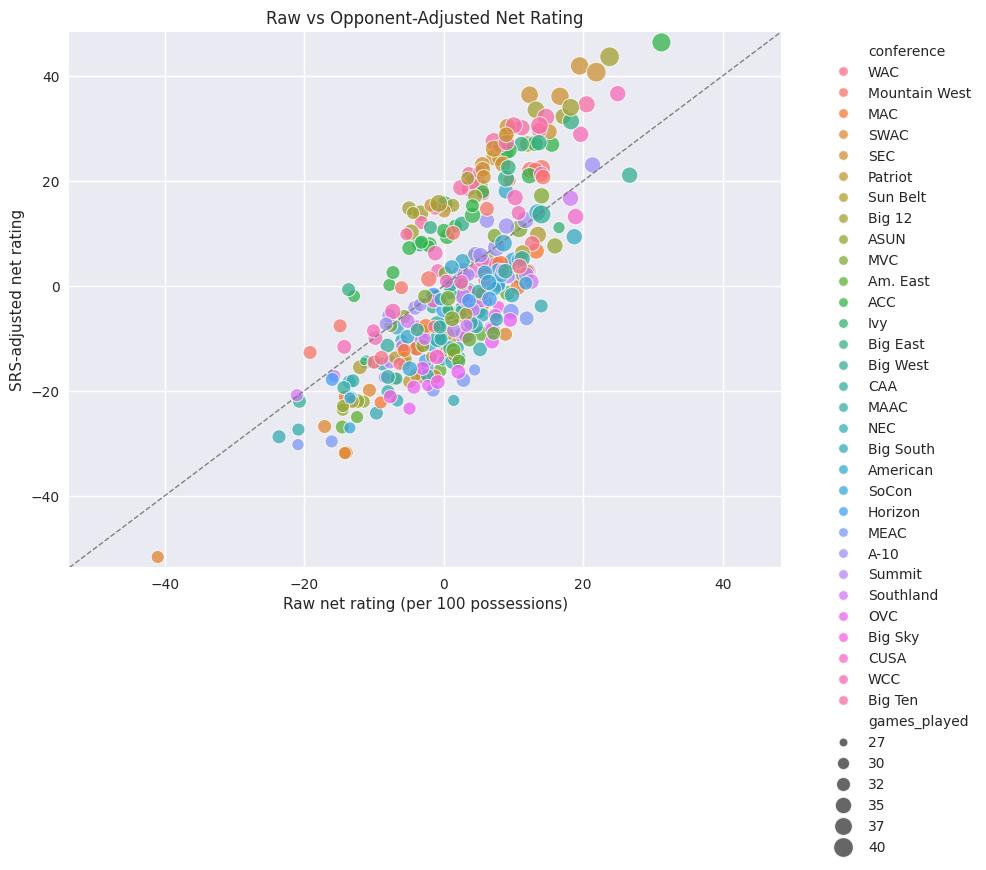

In [16]:
# 🔄 Raw vs adjusted net rating
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    data=opponent_adjusted,
    x='raw_net_rating',
    y='adj_net_rating',
    hue='conference',
    size='games_played',
    sizes=(40, 200),
    alpha=0.75,
    ax=ax
)
min_val = min(opponent_adjusted['raw_net_rating'].min(), opponent_adjusted['adj_net_rating'].min()) - 2
max_val = max(opponent_adjusted['raw_net_rating'].max(), opponent_adjusted['adj_net_rating'].max()) + 2
ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='gray', linewidth=1)
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_title('Raw vs Opponent-Adjusted Net Rating')
ax.set_xlabel('Raw net rating (per 100 possessions)')
ax.set_ylabel('SRS-adjusted net rating')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 📅 Strength-of-schedule extremes
These tables show who played the hardest and easiest opponents. Use them to sanity-check the adjusted rankings from the previous step.

Surface teams with the toughest and softest schedules to understand who earned their records.


In [17]:
# 🧱 Toughest schedules
toughest_sos = opponent_adjusted.sort_values('sos', ascending=False).head(10)
display(toughest_sos[['team', 'conference', 'wins', 'losses', 'sos', 'adj_net_rating', 'net_delta']])

easiest_sos = opponent_adjusted.sort_values('sos').head(10)
display(easiest_sos[['team', 'conference', 'wins', 'losses', 'sos', 'adj_net_rating', 'net_delta']])


,team,conference,wins,losses,sos,adj_net_rating,net_delta
4,Alabama,SEC,28,9,24.08,36.40,24.08
15,Auburn,SEC,32,6,22.41,41.91,22.41
134,Kentucky,SEC,24,12,21.12,30.31,21.12
235,Purdue,Big Ten,24,12,20.51,30.58,20.51
10,Arizona,Big 12,24,13,20.30,33.54,20.30
169,Michigan,Big Ten,27,10,20.29,27.51,20.29
130,Kansas,Big 12,21,13,20.09,29.25,20.09
112,Houston,Big 12,35,5,19.85,43.65,19.85
292,Texas A&M,SEC,23,11,19.81,28.79,19.81
9,Arizona State,Big 12,13,20,19.72,14.77,19.72


,team,conference,wins,losses,sos,adj_net_rating,net_delta
340,Wagner,NEC,14,16,-23.28,-21.83,-23.28
198,North Carolina Central,MEAC,14,19,-20.78,-17.95,-20.78
66,Delaware State,MEAC,16,14,-20.46,-16.01,-20.46
324,UT Martin,OVC,14,19,-18.50,-16.39,-18.50
348,Western Illinois,OVC,12,19,-18.49,-23.38,-18.49
181,Morgan State,MEAC,14,18,-18.38,-19.87,-18.38
273,Southern,SWAC,20,12,-18.10,-9.22,-18.10
266,South Carolina State,MEAC,20,13,-18.10,-6.20,-18.10
43,Central Connecticut,NEC,25,7,-17.82,-3.83,-17.82
3,Alabama A&M,SWAC,10,22,-17.81,-31.78,-17.81


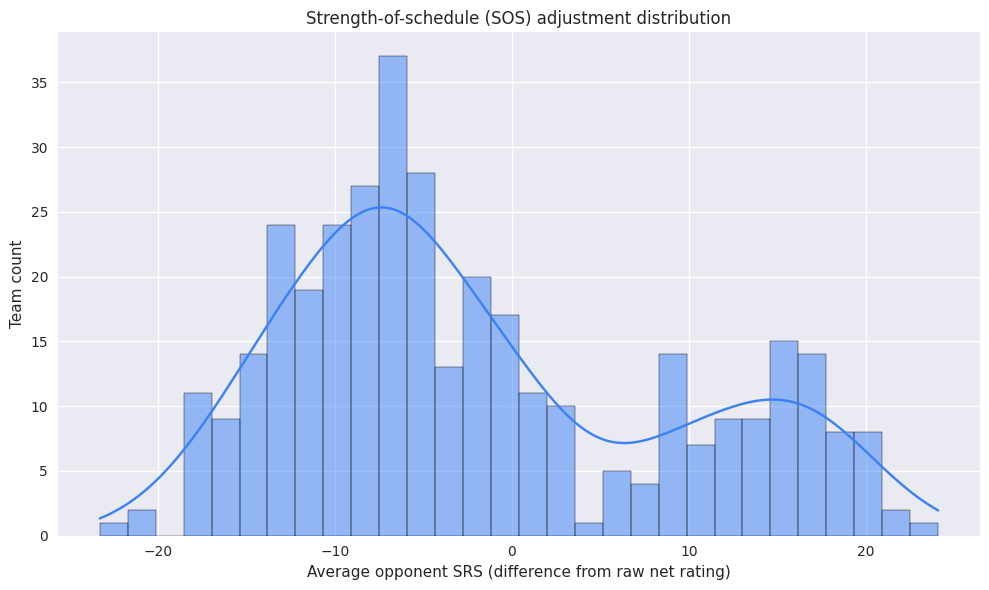

In [18]:
# 📊 Distribution of schedule impact
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(opponent_adjusted['sos'], bins=30, kde=True, color='#3B82F6', ax=ax)
ax.set_title('Strength-of-schedule (SOS) adjustment distribution')
ax.set_xlabel('Average opponent SRS (difference from raw net rating)')
ax.set_ylabel('Team count')
plt.tight_layout()
plt.show()


## ✅ Next steps
Document any surprising movers so you can investigate them in scouting or player-focused notebooks.

- Export the `opponent_adjusted` table to CSV for downstream scouting workflows.
- Blend SRS results with `02_build_simple_rankings.ipynb` to compare pace-adjusted and opponent-adjusted leaderboards.
- Layer in venue splits or recency filters (e.g., last 10 games) by rerunning the SRS solve on filtered game logs.
